In [21]:
from optimization import *
torch.set_default_dtype(torch.float64)

We consider a Business Process Simulation Model: BPSM = (W, R, D, P, T, I) where W is a WF-graph:


```mermaid
flowchart LR
    %% Order Handling WF-graph (Fig. 1)

    %% Events
    Start([Start Event])
    End([End Event])

    %% Tasks
    CCI["Collect Customer Info."]
    CEP["Collect Express Payment"]
    CSP["Collect Standard Payment"]
    PP["Prepare Package"]
    PI["Prepare Invoice"]
    SI["Send Invoice"]

    %% Gateways
    G_pay{{Payment type?}}
    G_and_split{{AND-split}}
    G_and_join{{AND-join}}

    %% Flow
    Start --> CCI
    CCI --> G_pay

    %% XOR on payment type
    G_pay -->|"Express"| CEP
    G_pay -->|"Standard"| CSP

    %% After payment, parallel branch
    CEP --> G_and_split
    CSP --> G_and_split

    %% AND-split to two parallel branches
    G_and_split --> PP
    G_and_split --> PI

    %% Invoice branch
    PI --> SI

    %% AND-join after package is ready and invoice is sent
    PP --> G_and_join
    SI --> G_and_join

    G_and_join --> End

```


R = 1; D are the distributions describing the duration of activities and are modelled with Gaussian distributions each with a specific mean and variance; P, which is a function that assigns a probability to each conditional flow is modelled with a transition matrix (in order to possibly handle also cycles).

Just for now, we neglect the waiting time distributions (T) and the interarrivals time distribution (I)

In [22]:
import torch
from torch.distributions import Normal, Categorical
import math

def simulate_bpmn(
    start_state: int,
    end_state: int,
    transition_matrix: torch.Tensor,
    duration_params: dict,
    and_splits: dict,
    join_map: dict,
    join_predecessors: dict,
    max_steps: int = 2000
):
    """
    BPMN simulator returning:
      - event log
      - flat vector of activity durations [d1, ..., dk]
      - activity_index_map = {activity_node: index}
    """

    # Map activity node -> index in the duration vector
    activity_index_map = {node: i for i, node in enumerate(duration_params.keys())}

    # Initialize the flat duration vector
    # None = activity not executed
    K = len(duration_params)
    flat_durations = [None] * K

    log = []
    current_time = 0.0

    active = [{"node": start_state, "remaining": 0.0, "start_time": current_time}]
    steps = 0

    while steps < max_steps:
        steps += 1
        if len(active) == 0:
            break

        # -----------------------------
        # Step 1: Assign durations
        # -----------------------------
        for t in active:
            node = t["node"]

            if t["remaining"] > 0:
                continue

            if node in duration_params:
                mean, std = duration_params[node]
                dur = Normal(mean, std).sample().item()
                t["remaining"] = dur
                t["start_time"] = current_time

                # record in flat vector (overwrite if multiple executions)
                idx = activity_index_map[node]
                flat_durations[idx] = dur

            else:
                # instantaneous
                t["remaining"] = 0.0
                t.setdefault("start_time", current_time)

        # -----------------------------
        # Step 2: advance time
        # -----------------------------
        min_remaining = min(t["remaining"] for t in active)
        current_time += min_remaining
        for t in active:
            t["remaining"] -= min_remaining

        # -----------------------------
        # Step 3: completed tasks
        # -----------------------------
        completed = [t for t in active if t["remaining"] <= 1e-9]

        for t in completed:
            log.append((t["node"], t["start_time"], current_time))

        for t in completed:
            active.remove(t)

        # -----------------------------
        # Step 4: successors
        # -----------------------------
        for task in completed:
            node = task["node"]

            if node == end_state:
                return log, flat_durations, activity_index_map

            # AND split
            if node in and_splits:
                for child in and_splits[node]:
                    active.append({
                        "node": child,
                        "remaining": 0.0,
                        "start_time": current_time
                    })
                continue

            # AND join
            if node in join_map:
                join_node = join_map[node]
                preds = join_predecessors[join_node]

                if all(any(ev[0] == p for ev in log) for p in preds):
                    active.append({
                        "node": join_node,
                        "remaining": 0.0,
                        "start_time": current_time
                    })
                continue

            # XOR
            probs = transition_matrix[node]
            next_node = Categorical(probs).sample().item()

            active.append({
                "node": next_node,
                "remaining": 0.0,
                "start_time": current_time
            })

    return log, flat_durations, activity_index_map


In [23]:
def simulate_n(
    n,
    start_state,
    end_state,
    transition_matrix,
    duration_params,
    and_splits,
    join_map,
    join_predecessors
):
    all_logs = []
    all_flat_durations = []
    activity_index_map = None

    for _ in range(n):
        log, flat_durations, idx_map = simulate_bpmn(
            start_state,
            end_state,
            transition_matrix,
            duration_params,
            and_splits,
            join_map,
            join_predecessors
        )

        all_logs.append(log)
        all_flat_durations.append(flat_durations)
        activity_index_map = idx_map

    return all_logs, all_flat_durations, activity_index_map


In [24]:

join_predecessors = {
    9: [6, 8]   # join node 9 waits for 6 and 8
}

join_map = {
    6: 9,
    8: 9
}

and_splits = {
    5: [6, 7]   # after split, run 6 and 7 in parallel
}


P = torch.tensor([
    #0   1   2   3    4   5   6   7   8   9   10
    [0,  1,  0,   0,   0,  0,  0,  0,  0,  0,   0],   # 0 -> 1
    [0,  0,  1,   0,   0,  0,  0,  0,  0,  0,   0],   # 1 -> 2
    [0,  0,  0, 0.4, 0.6,  0,  0,  0,  0,  0,   0],   # XOR
    [0,  0,  0,   0,   0,  1,  0,  0,  0,  0,   0],   # 3 -> 5
    [0,  0,  0,   0,   0,  1,  0,  0,  0,  0,   0],   # 4 -> 5
    [0,  0,  0,   0,   0,  0,  0,  0,  0,  0,   0],   # AND-split handled separately
    [0,  0,  0,   0,   0,  0,  0,  0,  0,  1,   0],   # 6 -> join
    [0,  0,  0,   0,   0,  0,  0,  0,  1,  0,   0],   # 7 -> 8
    [0,  0,  0,   0,   0,  0,  0,  0,  0,  1,   0],   # 8 -> join
    [0,  0,  0,   0,   0,  0,  0,  0,  0,  0,   1],   # 9 -> end
    [0,  0,  0,   0,   0,  0,  0,  0,  0,  0,   1],   # end
])

duration_params = {
    1: (2.0, 0.3),
    3: (1.0, 0.2),
    4: (3.0, 0.5),
    6: (5.0, 1.0),
    7: (4.0, 1.0),
    8: (1.0, 0.2),
}

log, flat_durations, activity_index_map = simulate_bpmn(
    start_state=0,
    end_state=10,
    transition_matrix=P,
    duration_params=duration_params,
    and_splits=and_splits,
    join_map=join_map,
    join_predecessors=join_predecessors,
    max_steps=1000
)

print(log)
print(flat_durations)
print(activity_index_map)


[(0, 0.0, 0.0), (1, 0.0, 2.0936445240770185), (2, 2.0936445240770185, 2.0936445240770185), (3, 2.0936445240770185, 3.4392975093205838), (5, 3.4392975093205838, 3.4392975093205838), (6, 3.4392975093205838, 8.873314099000439), (7, 3.4392975093205838, 9.496620709516348), (8, 9.496620709516348, 10.359106858696116), (9, 10.359106858696116, 10.359106858696116), (10, 10.359106858696116, 10.359106858696116)]
[2.0936445240770185, 1.345652985243565, None, 5.434016589679855, 6.057323200195764, 0.862486149179767]
{1: 0, 3: 1, 4: 2, 6: 3, 7: 4, 8: 5}


In [25]:
log, flat_durations, activity_index_map = simulate_n(
    1000,
    start_state=0,
    end_state=10,
    transition_matrix=P,
    duration_params=duration_params,
    and_splits=and_splits,
    join_map=join_map,
    join_predecessors=join_predecessors
)

print(log)
print(flat_durations)
print(activity_index_map)


[[(0, 0.0, 0.0), (1, 0.0, 2.553275995163498), (2, 2.553275995163498, 2.553275995163498), (4, 2.553275995163498, 5.160012287733222), (5, 5.160012287733222, 5.160012287733222), (7, 5.160012287733222, 8.134762957539383), (8, 8.134762957539383, 9.095036726320876), (6, 5.160012287733222, 9.499570001633202), (9, 9.499570001633202, 9.499570001633202), (10, 9.499570001633202, 9.499570001633202)], [(0, 0.0, 0.0), (1, 0.0, 1.8067050493864347), (2, 1.8067050493864347, 1.8067050493864347), (3, 1.8067050493864347, 2.9956189947122827), (5, 2.9956189947122827, 2.9956189947122827), (7, 2.9956189947122827, 4.747364873597411), (8, 4.747364873597411, 5.7548192501650925), (6, 2.9956189947122827, 5.985444091522541), (9, 5.985444091522541, 5.985444091522541), (10, 5.985444091522541, 5.985444091522541)], [(0, 0.0, 0.0), (1, 0.0, 1.9907200388809363), (2, 1.9907200388809363, 1.9907200388809363), (4, 1.9907200388809363, 4.848359311742624), (5, 4.848359311742624, 4.848359311742624), (6, 4.848359311742624, 8.3907

In [26]:
def merge_activity_1_2(flat_vector):
    """
    Merge flat_vector[1] and flat_vector[2].
    Exactly one should be None.
    Returns a NEW list where index 1 = merged value and index 2 is removed.
    """
    d1 = flat_vector[1]   # activity at index 1
    d2 = flat_vector[2]   # activity at index 2

    if d1 is not None:
        merged = d1
    elif d2 is not None:
        merged = d2
    else:
        merged = None  # Should not happen (XOR branch)
    
    # new vector:
    # keep index 0 unchanged
    # assign merged to index 1
    # remove old index 2
    # keep the rest untouched

    new_vector = (
        [flat_vector[0], merged]     # index 0 and merged index 1
        + flat_vector[3:]            # skip old index 2
    )

    return new_vector


def preprocess_dataset(all_flat_durations):
    """
    Apply merge_activity_1_2 to each simulation result.
    Returns: merged dataset (list of flat vectors WITHOUT the None column)
    """
    merged_dataset = []
    for flat in all_flat_durations:
        merged_flat = merge_activity_1_2(flat)
        merged_dataset.append(merged_flat)
    return merged_dataset

# 2. Preprocess dataset (merge activities 1 and 2)
clean_durations = preprocess_dataset(flat_durations)




In [27]:
soga_code = """
array[5] tactivities;
t = 0;

/* Collect customer information */

tactivities[0] = gm([1], [_muinfo], [_sigmainfo]);
t = t + tactivities[0]; 

/* Payment */

choice = uniform([0., 1.], 2);
if choice < 0.4 {
    /* Pay electronically */
    tactivities[1] = gm([1], [_mupayE], [_sigmapayE]);
    t = t + tactivities[1];
} else {
    /* Pay standard */
    tactivities[1] = gm([1], [_mupayS], [_sigmapayS]);
    t = t + tactivities[1];
} end if;


/* Parallel activities */

tactivities[2] = gm([1], [_mupack], [_sigmapack]);
tactivities[3] = gm([1], [_muprepinv], [_sigmaprepinv]);
tactivities[4] = gm([1], [_musendinv], [_sigmasendinv]);

if tactivities[2] - tactivities[3] - tactivities[4] > 0. {
    t = t + tactivities[2];
} else {
    t = t + tactivities[3] + tactivities[4];
} end if;

"""




In [28]:
# the activities are: info, payment (E or S), pack, prep_inv, send_inv
params = {'muinfo':  2., 'sigmainfo':0.3, 
          'mupayE':  1., 'sigmapayE':0.2,
          'mupayS':  3., 'sigmapayS':0.5,
          'mupack':  5., 'sigmapack':1.,
          'muprepinv':  4., 'sigmaprepinv':1.,
          'musendinv':  1., 'sigmasendinv':0.2,}
params_dict = initialize_params(params) 
compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict) 

In [29]:
y = []
y_var = []
for i in range(5):
    y.append(output_dist.gm.mean()[output_dist.var_list.index('tactivities['+ str(i) +']')].detach().numpy())
    y_var.append(torch.sqrt(output_dist.gm.cov()[output_dist.var_list.index('tactivities['+ str(i) +']'), output_dist.var_list.index('tactivities['+ str(i) +']')]).detach().numpy())

output_dist.gm.marg_pdf(torch.tensor(1.).unsqueeze(0), output_dist.var_list.index('tactivities[0]'))


tensor([[0.0051]], grad_fn=<MmBackward0>)

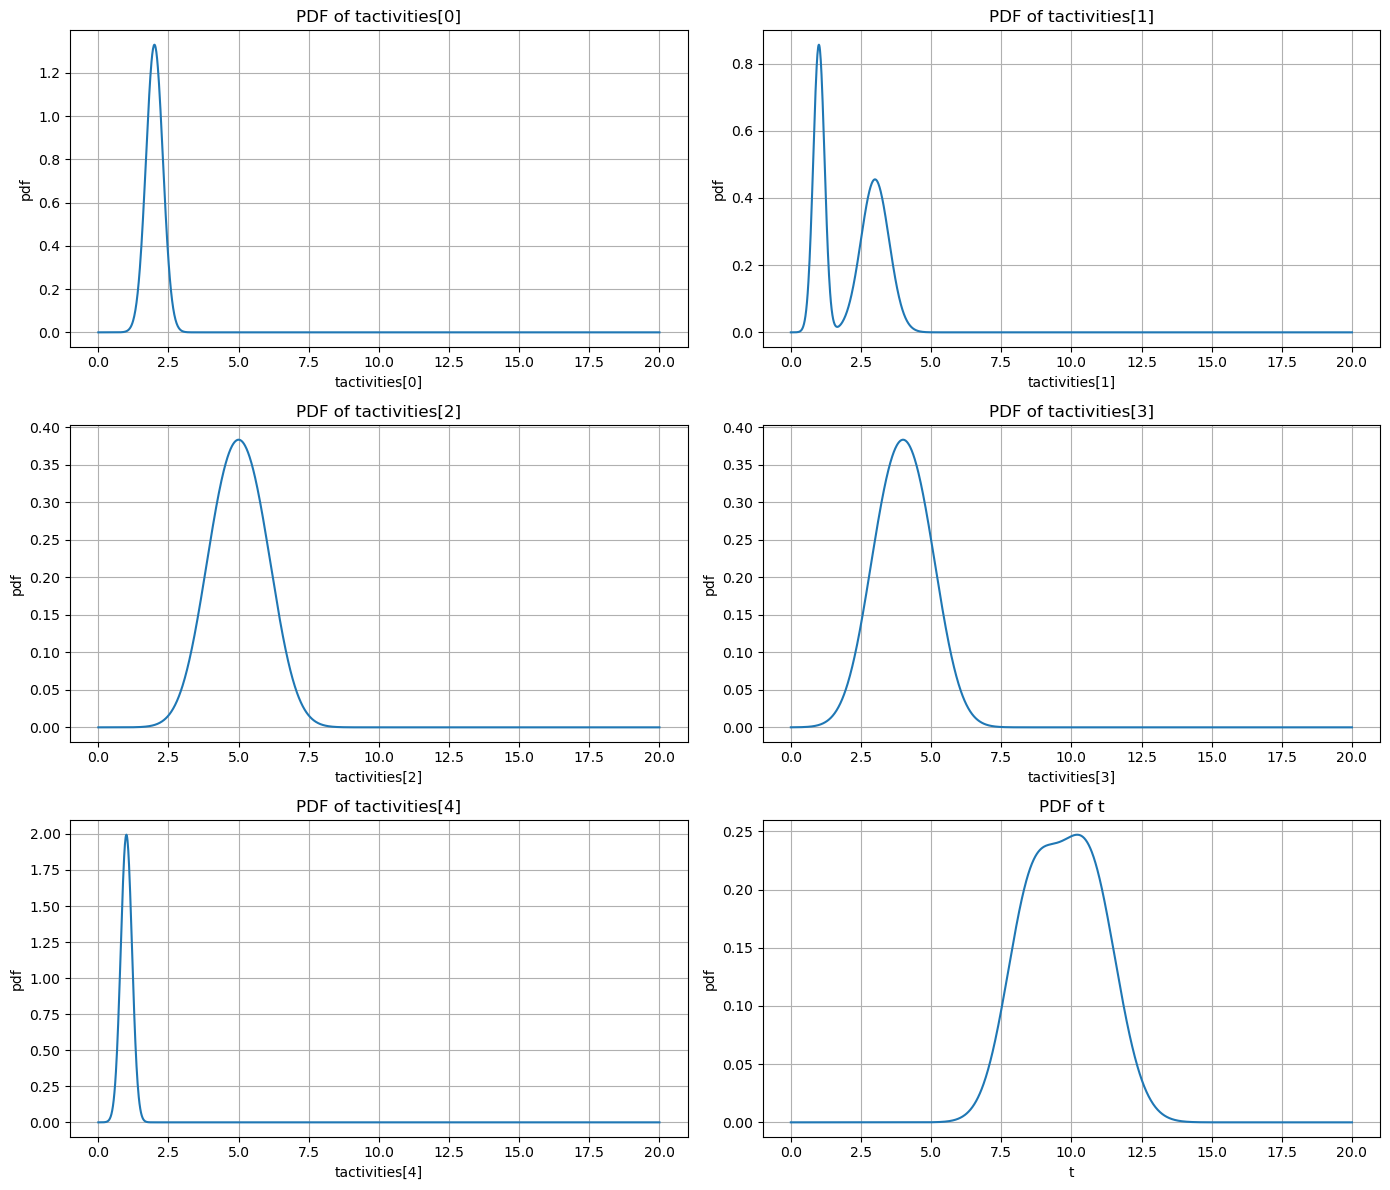

In [30]:
import torch
import matplotlib.pyplot as plt

def evaluate_marginal(output_dist, var_name, x_min, x_max, num_points=1000):
    """Evaluate marginal pdf pointwise to avoid shape mismatch issues."""
    idx = output_dist.var_list.index(var_name)
    xs = torch.linspace(x_min, x_max, num_points)

    pdf_vals = []
    for x in xs:
        # x needs to be shaped like your working call
        val = output_dist.gm.marg_pdf(x.unsqueeze(0), idx)
        pdf_vals.append(val.item())

    return xs, torch.tensor(pdf_vals)


def plot_grid_marginals(output_dist, var_names, x_min=0.0, x_max=20.0, num_points=1000):
    """Plot multiple marginal PDFs in a 3x2 grid."""
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i, var_name in enumerate(var_names):
        xs, pdf = evaluate_marginal(output_dist, var_name, x_min, x_max, num_points)

        ax = axes[i]
        ax.plot(xs.numpy(), pdf.numpy())
        ax.set_title(f"PDF of {var_name}")
        ax.set_xlabel(var_name)
        ax.set_ylabel("pdf")
        ax.grid(True)

    plt.tight_layout()
    plt.show()


# -----------------------------------------------------
# VARIABLES YOU WANT TO PLOT
# -----------------------------------------------------
variables_to_plot = [
    "tactivities[0]",
    "tactivities[1]",
    "tactivities[2]",
    "tactivities[3]",
    "tactivities[4]",
    "t"                   # total time or completion time
]

# -----------------------------------------------------
# CALL THE PLOTTING FUNCTION
# -----------------------------------------------------
plot_grid_marginals(output_dist, variables_to_plot, x_min=0.0, x_max=20.0, num_points=1500)


In [31]:
def plot_pdf_with_histograms_clean(
    output_dist,
    clean_durations,
    x_min=0.0,
    x_max=20.0,
    num_points=600
):

    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    axes = axes.flatten()

    # ------------------------------------
    # Variable names for the 5 activities
    # ------------------------------------
    variable_names = [
        "tactivities[0]",
        "tactivities[1]",
        "tactivities[2]",   
        "tactivities[3]",
        "tactivities[4]",
        "t"
    ]

    # ------------------------------------
    # Plot each variable
    # ------------------------------------
    for plot_idx, var_name in enumerate(variable_names):

        ax = axes[plot_idx]

        # PDF
        xs, pdf = evaluate_marginal(output_dist, var_name, x_min, x_max, num_points)
        ax.plot(xs.numpy(), pdf.numpy(), label="PDF")
        if var_name != "t":
            # Histogram (clean_durations contains NO None now)
            vals = [run[plot_idx] for run in clean_durations if run[plot_idx] is not None]

            ax.hist(vals, bins=30, density=True, alpha=0.4)
        ax.set_title(var_name)
        ax.grid(True)

    # Empty last cell
    axes[-1].axis("off")

    plt.tight_layout()
    plt.show()


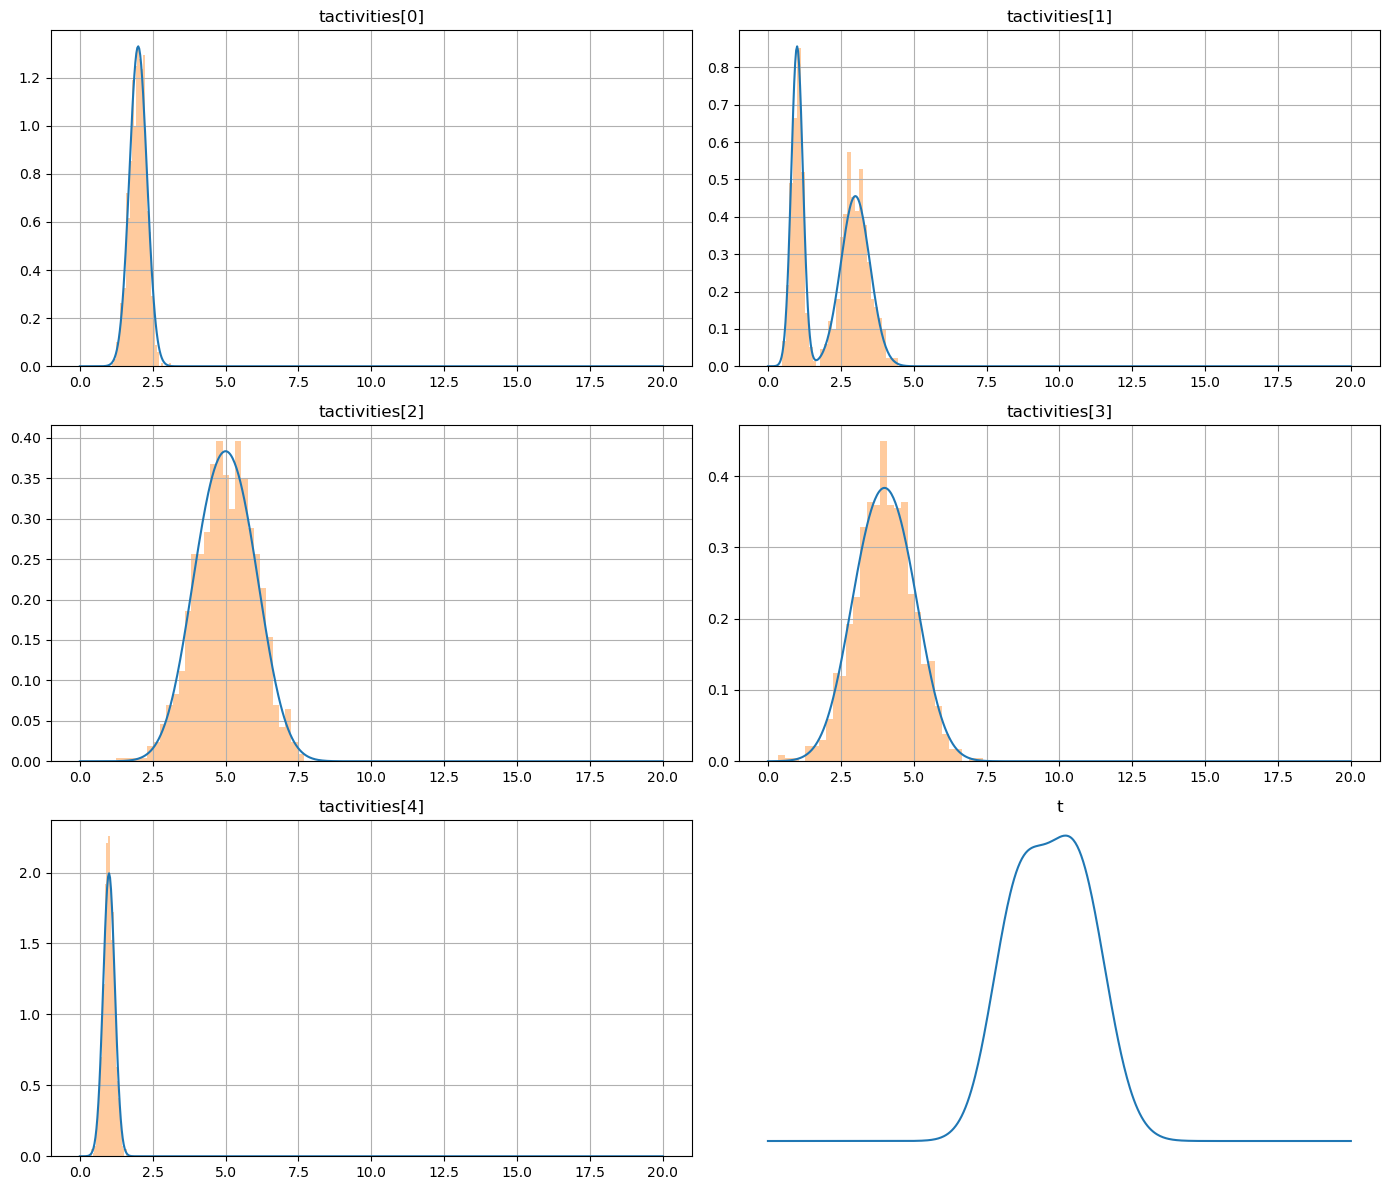

In [32]:
# 3. Plot PDFs + Histograms
plot_pdf_with_histograms_clean(
    output_dist,
    clean_durations,
    x_min=0.0,
    x_max=20.0
)

In [ ]:
var_index = [output_dist.var_list.index('tactivities['+ str(i) +']') for i in range(5)]
neg_log_likelihood(torch.tensor(clean_durations), output_dist, var_index)

tensor(3828.1842, grad_fn=<NegBackward0>)

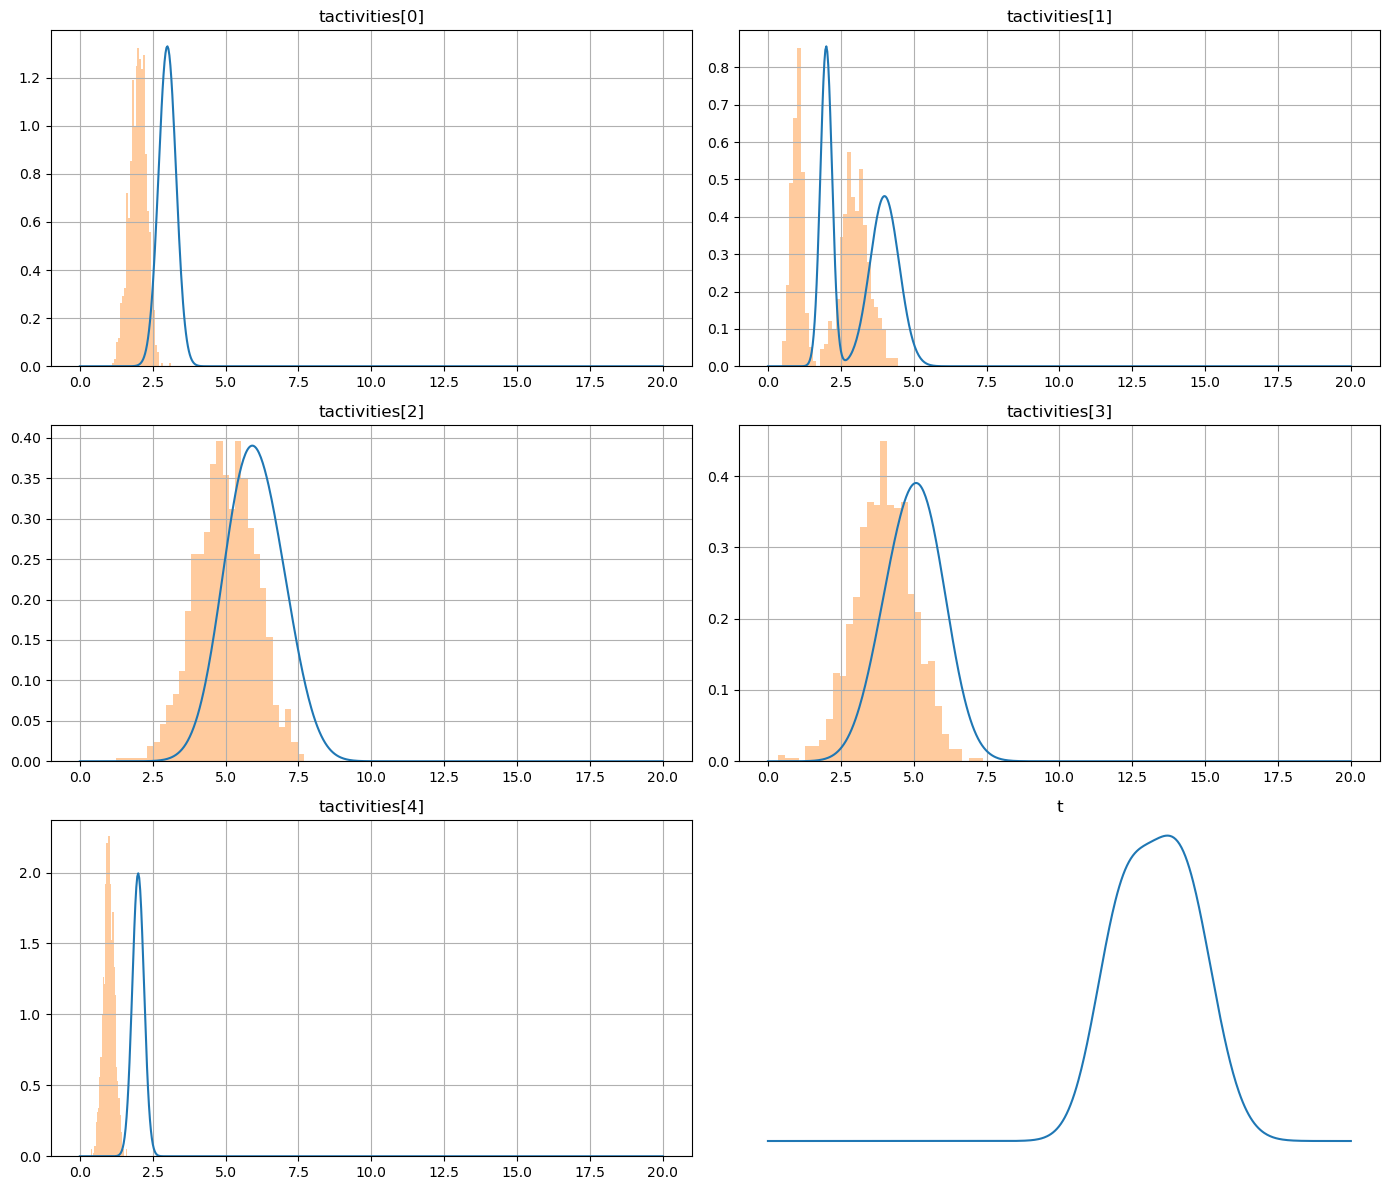

In [41]:
loss = lambda dist : neg_log_likelihood(torch.tensor(clean_durations), dist, var_index)
#add 1 to all the means
params = {'muinfo':  3., 'sigmainfo':0.3, 
          'mupayE':  2., 'sigmapayE':0.2,
          'mupayS':  4., 'sigmapayS':0.5,
          'mupack':  6., 'sigmapack':1.,
          'muprepinv':  5., 'sigmaprepinv':1.,
          'musendinv':  2., 'sigmasendinv':0.2,}

params_dict = initialize_params(params)

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)
output_dist = start_SOGA(cfg, params_dict)
plot_pdf_with_histograms_clean(
    output_dist,
    clean_durations,
    x_min=0.0,
    x_max=20.0
)

muinfo: 1.8086655080775098 sigmainfo: 0.5063219783163209 mupayE: 1.3060719196218504 sigmapayE: 1.2015416793062101 mupayS: 3.0558844459782137 sigmapayS: 0.4871273122920594 mupack: 4.825244299928232 sigmapack: 1.1894197252726741 muprepinv: 3.8190907061024393 sigmaprepinv: 1.1727167943638501 musendinv: 0.9390218178854759 sigmasendinv: 0.9836472537245707  loss: 6213.017954167356
muinfo: 1.9516857624099917 sigmainfo: 0.30720886423210636 mupayE: 1.469948887853137 sigmapayE: 1.0014813798878552 mupayS: 3.2078786512539397 sigmapayS: 0.2913955587911726 mupack: 4.947023369843232 sigmapack: 1.0439231612871658 muprepinv: 3.954614219144994 sigmaprepinv: 1.026474141319903 musendinv: 1.1141003790882609 sigmasendinv: 0.7836280977449461  loss: 5798.576735533469
muinfo: 2.1127267722114196 sigmainfo: 0.137232579408917 mupayE: 1.5986199299013832 sigmapayE: 0.8032877105389569 mupayS: 3.106546451288102 sigmapayS: 0.386303093064606 mupack: 5.08002635505795 sigmapack: 0.8990231456704776 muprepinv: 4.0982548022

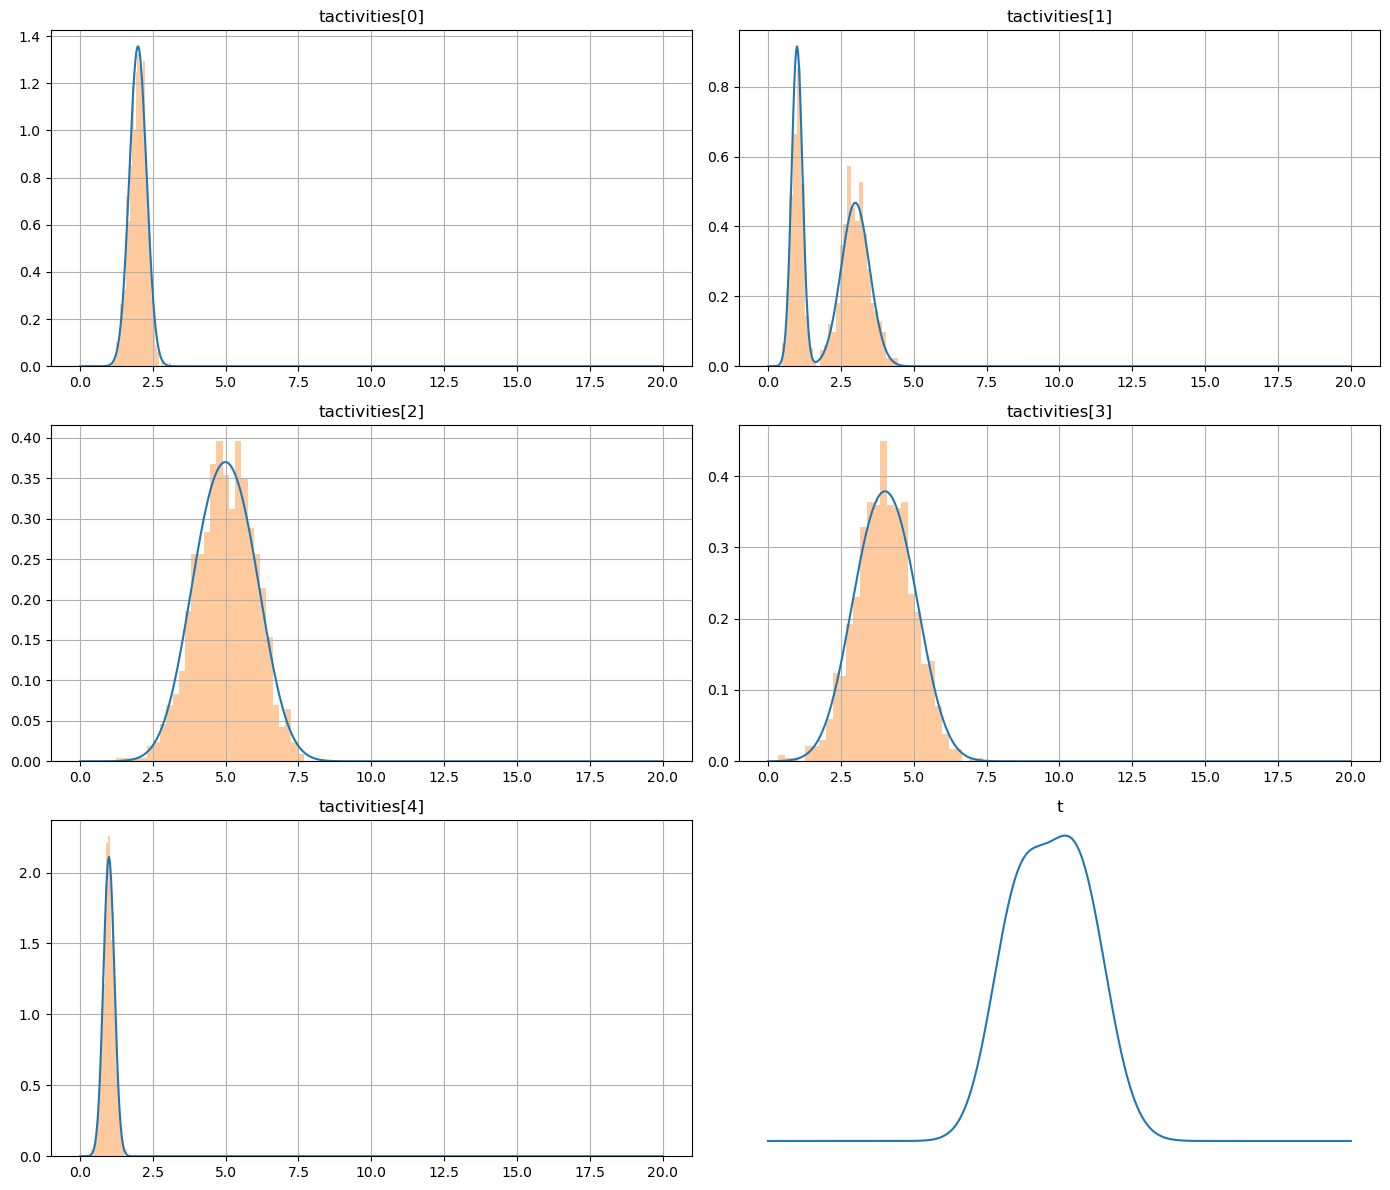

In [43]:
# gradient based optimization
loss_list = optimize(cfg, params_dict, loss, n_steps=200, lr=0.2)

# print results:
for key, value in params_dict.items():
    print(f"{key}: {value.item()}")

compiledFile = compile2SOGA_text(soga_code)
cfg = produce_cfg_text(compiledFile)
smooth_cfg(cfg)

output_dist = start_SOGA(cfg, params_dict)
plot_pdf_with_histograms_clean(
    output_dist,
    clean_durations,
    x_min=0.0,
    x_max=20.0
)